## LINMA1702 - Projet
# Utilisation optimale d'une pompe à chaleur domestique

###  Notebook pour le rapport final - version 2.1
### <font color="red">Numéro du groupe : 7</font>
### <font color="red">Membres du groupe :

Englebert Alexis (37862100)

Sanglier Kevin (23832000)

Lamby Thomas (27312000)

Rota-Benadid Lucas (79162100)</font>

## Description générale

Une pompe à chaleur permet de chauffer un bâtiment en consommant moins d'énergie qu'au chauffage électrique classique, grâce à un coefficient de performance (COP) supérieur à un. Elle peut également fonctionner de façon réversible, c'est-à-dire qu'elle permet de refroidir en été.

Dans ce projet, on va utiliser une pompe à chaleur pour maintenir le température intérieur d'un bâtiment dans une plage confortable, tout en minimisant le coût de l'électricité consommée.

### Hypothèses et données
- On considère une année entière, qu'on discrétise par intervalles de temps d'une durée de 15 minutes
- Le bâtiment est situé à Montréal, et on dispose de la température extérieure durant chaque intervalle de temps 
- On suppose que la température du bâtiment est homogène, et on s'intéressera uniquement à la valeur qu'elle prend toutes les 15 minutes (on ne s'intéresse donc pas à la dynamique de la température au cours d'un intervalle de temps)
- Durant chaque intervalle de temps la température intérieure évolue en fonction la température externe : la différence de température entre le début et la fin d'un intervalle de temps est proportionnel à la différence entre la température externe et la température interne (le coefficient de proportionnalité dépendant de l'isolation du bâtiment)
- Pendant chaque intervalle de temps on peut choisir d'activer la pompe à chaleur. Plus précisément, on peut décider de la puissance qu'on va utiliser pour la pompe à chaleur, jusqu'à une certaine puissance maximale. Celle-ci va alors prélever de la chaleur extérieure et la transférer à l'intérieur du bâtiment (ou l'inverse si on décide de fonctionne en mode refroidissement, nommé "reverse"). La quantité de chaleur transférée est proportionnelle à la puissance électrique consommée, mais aussi au coefficient de performance (COP).
- La variation de la température du bâtiment causée par l'activation de la pompe à chaleur est proportionnelle à la chaleur/énergie transférée
- Le coefficient de performance de la pompe à chaleur est supposé dépendre uniquement de la température extérieure et du mode de fonctionnement, normal ou reverse.
- Le coût unitaire de l'électricité consommée dépend de l'heure où elle est prélevée (tarif bi-horaire)
   
### Remarque à propos de la modélisation
En général, quand on modélise un problème, on décide d'effectuer certaines hypothèses et/ou approximations. Il y a certainement plusieurs façons tout à fait valides de modéliser le problème, donc pas pas forcément une unique bonne réponse. Vous pouvez interpréter l'énoncé de la façon qui vous convient le mieux du moment qu'elle reste raisonnable. 
(par exemple : l'énoncé suggère de ne pas analyser/de prendre en compte ce qui se passe à l'intérieur d'un intervalle de temps, ce qui est un choix ; aussi : le fonctionnement simultané en mode chauffage et reverse pourrait être a priori permis ou interdit, mais cela change-t-il vraiment les choses ?)

## Imports

In [1]:
import numpy as np # Pour les math
import matplotlib.pyplot as plt # Pour les graphiques
import cvxpy as cp
import time

## Données et Utils

In [12]:
# CONSTANTES
COP_CONST = 3.2
CAPACITE_CALORIFIQUE = 0.4
MIN_TEMP = 19
MAX_TEMP = 21
ETA  = 0.99
NIGHT_COST = 0.18
DAY_COST = 0.26
MAX_ENERGY = 1
temperatures_exterieurs = np.load("Temperatures-Montreal.npy")

# FONCTIONS UTILS
def is_night(idx):
    days_offset = 96
    day = (idx % days_offset)
    return True if day > 88 or day < 28 else False

def degree_to_get(reference, outside_temperature , x_i):    
    if (reference < outside_temperature):
        return (COP_CONST * CAPACITE_CALORIFIQUE * x_i) 
    else:
        COP_TEX = 3 + 10 * abs(np.tanh(outside_temperature/100)) * np.tanh(outside_temperature/100)
        return (COP_TEX * CAPACITE_CALORIFIQUE * x_i)

# FONCTIONS D'AFFICHAGE
def display_temperature(Tin, temperatures_exterieurs, start_idx):
    axe_x = range(672)
    fig, ax = plt.subplots()
    ax.add_patch(plt.Rectangle((0, MIN_TEMP), 672, (MAX_TEMP - MIN_TEMP), alpha=.2))
    ax.plot(axe_x, Tin.value, label="Température intérieure", color="red")
    ax.plot(axe_x, temperatures_exterieurs[start_idx:start_idx+672], label="Température extérieure", color="black")
    plt.legend()
    plt.title("Comparaison entre la température extérieure et intérieure")
    plt.xlabel("Intervalles de 15 minutes")
    plt.ylabel("Température (en °C)")
    plt.show()

def display_energy(valeur_energie):
    axe_x = range(672)
    refroidissement = []
    rechauffement = []
    for i in valeur_energie:
        if i < 0:
            refroidissement.append(i)
            rechauffement.append(0)
        else:
            rechauffement.append(i)
            refroidissement.append(0)
    fig, ax = plt.subplots()
    ax.bar(axe_x, rechauffement, label="Pour réchauffer", color="red")
    ax.bar(axe_x, refroidissement, label="Pour refroidir", color="black")
    plt.legend()
    plt.title("Énergie utilisée par la pompe à chaleur")
    plt.xlabel("Intervalles de 15 minutes")
    plt.ylabel("Énergie consommée (en watts)")
    plt.show()

def display_energy_separated(chaud, froid, BOUNDARY=None):
    axe_x = range(672)
    #froid = list(map(lambda x : -1*x, froid))
    fig, ax = plt.subplots()
    ax.bar(axe_x, chaud, label="Pour réchauffer", color="red")
    ax.bar(axe_x, froid, label="Pour refroidir", color="black")
    if BOUNDARY is not None:
        ax.plot(axe_x, [BOUNDARY]*len(axe_x))
    plt.legend()
    plt.title("Énergie utilisée par la pompe à chaleur")
    plt.xlabel("Intervalles de 15 minutes")
    plt.ylabel("Énergie consommée (en watts)")
    plt.show()

#Création du graphe
def display_inconfort_budget(list_inconfort, list_budget):
    axe_x = [0,10,20,30,40,50,60,70,80,90,100]
    fig, ax = plt.subplots()
    #ax.bar(axe_x, list_inconfort, width=9, label="Inconfort total", color="red")
    ax.plot(axe_x, list_inconfort, label="Inconfort total", color="red")
    plt.legend()
    plt.title("Inconfort total en fonction du % du budget minimum (q1)")
    plt.xlabel("% du budget minimum")
    plt.show()

## Tâches

**Tâche 1** : on souhaite dans un premier temps que la température du bâtiment reste comprise dans une certaine plage admissible de températures, et on cherche à **minimiser le coût total de l'électricité consommée par la pompe à chaleur**. Formulez ce problème comme un problème d'optimisation linéaire, puis résolvez le.

Pour des raisons de temps de calcul, votre modèle considérera uniquement une période de 7 jours consécutifs. Il fera l'hypothèse que la température initiale au début de la période est égale à la valeur centrale de la plage admissible, et fera en sorte que la température finale à la fin de la période revienne à la même valeur. Votre code prendra donc en entrée un paramètre indiquant le numéro de l'intervalle de temps qui début la période, qui s'étendra sur $7 \times 24 \times 4 = 672$ intervalles de temps.

<div class="alert alert-block alert-warning"><b>A mentionner</b> :<br> 
- coût minimal + graphique de l'évolution des températures + graphique représentant l'utilisation de la pompe à chaleur (en distinguant le fonctionnement normal du fonctionnement _reverse_) + temps de calcul + bref commentaire (maximum 4 lignes)<br>
- pour deux périodes distinctes (placer les résultats côté à côté) : à gauche une période pré-déterminée (cf. fichier de données), et à droite une seconde période que vous choisirez en fonction de son intérêt
</div>

---

<div class="alert alert-block alert-info"><b>Question 1.1</b> :<br> 
    Donnez votre formulation linéaire, en commentant brièvement (en particulier si vous utilisez une technique de modélisation/reformulation).
</div>

# Variables de décison
Soit $x_i$ l'énergie utilisée en mode normal par la pompe à chaleur à l'intervalle de temps $i$.

# Objectif
Minimiser le coût total de l'électricité consommée par la pompe à chaleur.

Fonction objective : min $c^T * abs(x_i)$

où $c_i$ est le coût de l'électricité à l'intervalle de temps $i$.\
$c_i = 0.18$ si c'est la nuit\
ou\
$c_i = 0.26$ si c'est le jour\
et où $abs(x_i)$ est l'énergie utilisée.

# Contraintes
$x_i \le (1)$\
$x_i \ge (-1)$\
$x_i \ge (19-t_i)*(1/0.4)*(1/COP_{xi})$\
$x_i \le (21-t_i)*(1/0.4)*(1/COP_{xi})$\
$x_i \ge -(21-t_i)*(1/0.4)*(1/3.2)$\
$x_i \le -(19-t_i)*(1/0.4)*(1/3.2)$\
$t_{{in}_{i+1}} - t_{{in}_i} = -0.01 * (t_{{in}_i} - t_{{ex}_i})$\
$COP_{xi} = 3 + 10 * abs(tanh(t_{{ex}_i}/100)) * tanh(t_{{ex}_i}/100)$\
où $t_{{in}_i}$ est la température intérieure initiale à l'intervalle de temps $i$, $COP_{xi}$ le coefficent de performance de la pompe à chaleur en mode normal à l'intervalle de temps $i$, $t_{{in}_{i+1}}$ la température à l'intérieure après avoir utilisé (ou non) la pompe à chaleur à l'intervalle de temps $i$ et $t_{{ex}_i}$ est la température extérieure de Montréal à l'intervalle de temps $i$.

<div class="alert alert-block alert-info"><b>Question 1.2</b> :<br> 
    Résolvez votre modèle sur les deux intervalles de temps, affichez vos résultats sous forme graphique et commentez.
</div>

In [3]:
def task_1(i_idx):
    depart = time.time()
    end_idx = i_idx + 96*7
    cout_intervalle = [NIGHT_COST if is_night(i_idx) else DAY_COST]
    T0 = 20 # Température de départ
    x = cp.Variable(end_idx-i_idx)
    Tin = cp.Variable(end_idx-i_idx)
    contraintes = [
        Tin[0] == T0, 
        Tin[end_idx-i_idx-1] == T0
    ]
    
    for i in range(1, end_idx-i_idx):
        cout_intervalle.append(NIGHT_COST) if is_night(i + i_idx) else cout_intervalle.append(DAY_COST)
        T1 = -(1 - ETA) * (Tin[i-1] - temperatures_exterieurs[i+ i_idx]) + Tin[i-1] # Température initiale suivante
        degre_a_compenser = degree_to_get(20, temperatures_exterieurs[i+ i_idx], x[i])
        
        # Contrainte de degrée
        contraintes.append((T1 + degre_a_compenser == Tin[i]))
        contraintes.append(-Tin[i] <= -MIN_TEMP)
        contraintes.append(Tin[i] <= MAX_TEMP)
        
        # Contrainte d'énergie
        contraintes.append(x[i] <= MAX_ENERGY)
        contraintes.append(x[i] >= -MAX_ENERGY)

    fonction_cout = cp.sum(cp.multiply(cout_intervalle, cp.abs(x)))
    solution = cp.Problem(cp.Minimize(fonction_cout), contraintes)
    solution.solve()

    fin = time.time() - depart
    #cout_intervalle = x.value * cout_intervalle    
    print(f"Le coût minimal pour l'instance {i_idx} est de {solution.value} $")
    print(f"Temps de calcul : {fin} s")
    return (solution.value, Tin, temperatures_exterieurs, x.value, fin)

In [4]:
min_cost, temperature_in, temperature_ext, énergie, _ = task_1(13050)
print()
min_cost2, temperature_in2, temperature_ext2, énergie2, _ = task_1(18500)

Le coût minimal pour l'instance 13050 est de 8.10396380565292 $
Temps de calcul : 3.465428113937378 s

Le coût minimal pour l'instance 18500 est de 2.414674662968298 $
Temps de calcul : 3.2373037338256836 s


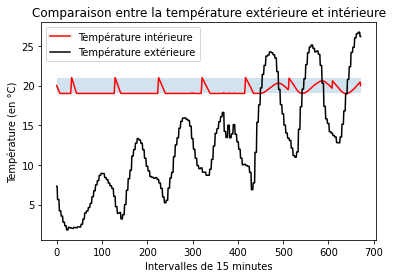

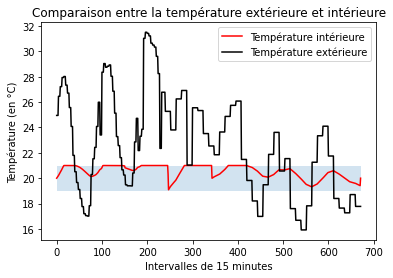

In [5]:
display_temperature(temperature_in, temperature_ext, 13050)
display_temperature(temperature_in2, temperature_ext2, 18500)

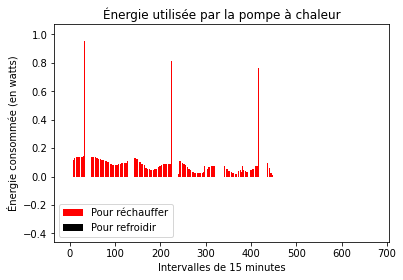

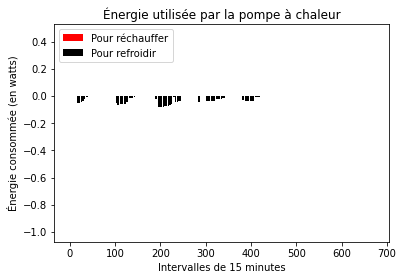

In [6]:
display_energy(énergie)
display_energy(énergie2)

# Commentaire
Les résultats observés sur nos graphes sont satisfaisants, on voit que toutes les contraintes du problème sont respectées. (Précision: Une énergie négative dans le graphe ne représente pas un gain d’énergie mais bien l’énergie dépensée en mode reverse). Nous avons choisi d’observer cette deuxième semaine car elle est très chaude et permet alors d’observer que la contrainte $x_i \ge -1$ est respectée.

<div class="alert alert-block alert-info"><b>Question 1.3</b> :<br> 
    A partir de certaines informations fournies par le solver (et donc sans effectuer de nouveau calcul) et de la théorie vue au cours, prédisez l'effet sur le coût optimal d'une diminution de la tempéature minimale admissible Tmin. Faites de même pour une augmentation de la température maximale admissible Tmax. 
    Votre prédiction consiste en un formule pour le coût optimal en fonction des deux variations de température Tmin et Tmax. Commentez cette prédiction (en particulier : est-elle valide pour n'importe quelle variation des températures ?).
</div>

Une diminution de $T_{min}$ et un augmentation de $T_{max}$ affecteraient notre résultat. En effet il faudrait activer moins de fois la pompe à chaleure dans le cas général. 

On peut donc affirmer qu'une diminution de $T_{min}$ et une augmentation de $T_{max}$ diminue/n'augmente pas le coût minimal.

$c^{*} \leq c$ \
\
où $c^{*}$ est le coût après diminution de $T_{min}$ et augmentation de $T_{max}$ \
et $c$ est le coût sans changement de borne.

<div class="alert alert-block alert-info"><b>Question 1.4</b> :<br> 
   Démontrez que, dans toute solution optimale de ce modèle, l'activation simultanée du chauffage et du mode reverse durant la même période de temps est impossible.
</div>

Suffit de démontrer que l'activation simultanée du chauffage et du mode reverse n'est jamais optimale dans ce problème. Pour ce faire on sait qu'on veut minimiser le coût de la pompe à chaleure. Étant donné qu'on veut soit chauffer ou refroidir la pièce alors ils ne serait pas optimale d'activer les deux étant donnés qu'ils s'anulleront alors qu'on aura dépensé de l'argent. En effet si jamais on active les deux modes en même temps alors on dépenseras $x_1$ énergie pour chauffer et $x_2$ énergie pour refroidir. On auras donc |x_1 - x_2| énergie réellement utilisée. Don on s'apperçoit que d'activer simultanément les deux mode n'est pas optimal.

<div class="alert alert-block alert-info"><b>Question 1.5</b> :<br> 
    Modifiez votre modèle de façon à tenir compte des deux nouvelles contraintes suivantes :<br>
    - si la pompe à chaleur est utilisée (dans un mode ou dans l'autre), elle l'est au moins à 25% de sa puissance maximale. Il n'est donc plus possible d'utiliser la pompe à chaleur à très faible puissance.
<br>
    - si on décide d'allumer (ou d'éteindre) la pompe à chaleur, elle reste allumée (ou éteinte) sur une période de x heures consécutives. Ces périodes sont fixes : par exemple, si x=4h, il s'agit de [0h-4h], [4h-8h], [8h-12h], [12h-16h], etc. pour chaque journée.<br>
    Le nouveau modèle sera toujours obligatoirement linéaire, mais pourra faire appel à des variables discrètes. 
    Donnez votre formulation, et commentez brièvement.
</div>

<div class="alert alert-block alert-info"><b>Question 1.6</b> :<br> 
    Résolvez ce nouveau modèle, affichez les résultats et commentez (en particulier le temps de calcul). Choissisez d'abord une valeur x=4h, puis x=2h.
</div>

In [7]:
MIN_POWER = 0.25

def task_1_p2(i_idx, CONTINIOUS_HOUR=0):
    depart = time.time()
    end_idx = i_idx + 96*7
    cout_intervalle = [NIGHT_COST if is_night(i_idx) else DAY_COST]
    T0 = 20 # Température de départ
    
    # Par simplicité on divise les deux énergies en deux variables différentes
    x = cp.Variable(end_idx-i_idx)
    y = cp.Variable(end_idx-i_idx)
    a = cp.Variable(end_idx-i_idx, boolean=True)
    b = cp.Variable(end_idx-i_idx, boolean=True)
    Tin = cp.Variable(end_idx-i_idx)
    contraintes = [
        Tin[0] == T0, 
        Tin[end_idx-i_idx-1] == T0
    ]

    for i in range(1, end_idx-i_idx):
        cout_intervalle.append(NIGHT_COST) if is_night(i + i_idx) else cout_intervalle.append(DAY_COST)
        T1 = -(1 - ETA) * (Tin[i-1] - temperatures_exterieurs[i+ i_idx]) + Tin[i-1] # Température initiale suivante
        COP_TEX = 3 + 10 * abs(np.tanh(temperatures_exterieurs[i+ i_idx]/100)) * np.tanh(temperatures_exterieurs[i+ i_idx]/100)
        degre_a_compenser_chauffage = COP_TEX * CAPACITE_CALORIFIQUE * x[i]
        degre_a_compenser_refroidissement = (COP_CONST * CAPACITE_CALORIFIQUE * y[i])
        
        # Contrainte de degrée
        contraintes.append((T1 + degre_a_compenser_chauffage - degre_a_compenser_refroidissement == Tin[i]))
        contraintes.append(-Tin[i] <= -MIN_TEMP)
        contraintes.append(Tin[i] <= MAX_TEMP)
        contraintes.append(x[i] <= MAX_ENERGY * a[i])
        contraintes.append(x[i] >= MIN_POWER * MAX_ENERGY * a[i])
        contraintes.append(y[i] <= MAX_ENERGY * b[i])
        contraintes.append(y[i] >=  MIN_POWER * MAX_ENERGY * b[i])

    if CONTINIOUS_HOUR != 0:
        indx = 0
        while indx < 96*7:
            for i in range(((CONTINIOUS_HOUR)*4)-1):
                contraintes.append(a[indx] == a[indx+1])
                contraintes.append(b[indx] == b[indx+1])
                indx += 1
            indx+=1

    fonction_cout = cp.sum(cp.multiply(cout_intervalle, cp.abs(x))) + cp.sum(cp.multiply(cout_intervalle, cp.abs(y)))
    solution = cp.Problem(cp.Minimize(fonction_cout), contraintes)
    solution.solve(solver=cp.SCIPY, scipy_options={"method": "highs"})

    fin = time.time() - depart
    #cout_intervalle = x.value * cout_intervalle
    print(f"Le coût minimal pour l'instance {i_idx} est de {solution.value} $")
    print(f"Temps de calcul : {fin} s")
    
    return (solution.value, Tin, temperatures_exterieurs, x.value, y.value, fin)

In [8]:
min_cost, temperature_in, temperature_ext, énergie_chaud, énergie_froid, _ = task_1_p2(13050, CONTINIOUS_HOUR=2)

Le coût minimal pour l'instance 13050 est de 8.366439765330552 $
Temps de calcul : 42.48505902290344 s


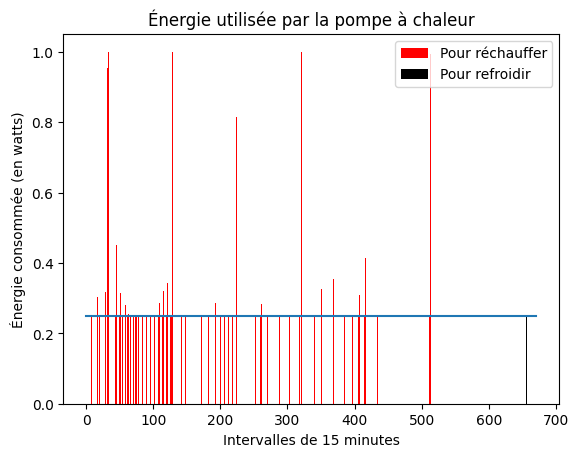

In [9]:
display_energy_separated(énergie_chaud, énergie_froid, BOUNDARY=MIN_POWER * MAX_ENERGY)

<div class="alert alert-block alert-info"><b>Question 1.7</b> :<br> 
    Décrivez comment on pourrait apporter les modifications suivantes au nouveau modèle de la Question 1.5, sans les implémenter : <br>
    (a) tenir compte d'un coût fixe supplémentaire à payer pour chaque intervalle de temps où la pompe à chaleur est utilisée<br>
    (b) empêcher le nombre total d'allumages de la pompe à chaleur à ne pas dépasser une certaine valeur maximale (un allumage = passage de l'état 'éteint' lors d'un invervalle de temps à l'état 'allumé' lors de l'intervalle de temps suivant)<br>
    (c) dans ce nouveau modèle il n'est plus nécessairement impossible d'observer dans une solution optimale l'activation simultanée du chauffage et du mode reverse au cours du même intervalle de temps : expliquez pourquoi, et proposez une contrainte permettant d'éliminer cette possibilité d'activation simultanée.
</div>

(a) si on définit le cout fixe comme était F alors, il suffit d'ajouter dans notre fonction objective $\sum_{i=0}^{672} F \cdot a_i + \sum_{i=0}^{672} F \cdot b_i $.\
\
(b) si on définit la valeure maximale comme étant V alors, Étant donné que la pompe à chaleure reste allumée sur une periode de X heure ce qui correspond à $X \cdot 4$ Intervales, on peut calculer le nombre d'allumages de la pome à chaleur comme suit : $\frac{\sum_{i=0}^{672} a_i + b_i}{X \cdot 4}$ et donc il suffit d'ajouter la contrainte suivante à notre modèle :$\frac{\sum_{i=0}^{672} a_i + b_i}{X \cdot 4} \leq V$.
\
\
(c) Étant donné que $a_i$ est une variable booléene qui vaut 1 quand la pompe à chaleur est en mode chauffage et 0 ou sinon et que $b_i$ est une variable booléenne qui vaut 1 quand la pome à chaleur est en mode reverse et 0 sinon alors, on en conclut que pour qu'une seule des deux soit égal à 1 est que cette équation soit satisfaite : $a_i \cdot b_i = 0$

**Tâche 2** : on souhaite réduire le coût d'utilisation de la pompe à chaleur, et on va fixer le budget maximal à une certaine proportion du coût minimal identifié lors de la première tâche. Pour diminuer les coût, on va permettre aux températures de sortir de la plage admissible définie plus haut (on abandonne aussi la contrainte sur la température finale, qui devient libre). On va cependant alors comptabiliser la quantité d'_inconfort_ éventuellement subi durant chaque intervalle de temps, qui sera proportionnel au dépassement de la température maximale admissible, ou au dépassement par le bas de la température minimale admissible. On cherche alors à **minimiser l'inconfort total** (somme des inconforts sur toute la période considérée) **tout en respectant la contrainte de budget**. Formulez ce problème comme un problème d'optimisation linéaire, puis résolvez le.


<div class="alert alert-block alert-warning"><b>A mentionner</b> :<br> 
- inconfort minimal + même graphiques que pour tâche 1 + temps de calcul + bref commentaire (maximum 4 lignes)<br>
- à nouveau pour les deux périodes mentionnées lors de la tâche 1
</div>

---

<div class="alert alert-block alert-info"><b>Question 2.1</b> :<br> 
    Donnez votre formulation linéaire, en commentant brièvement (en particulier si vous utilisez une technique de modélisation/reformulation).
</div>

# Variables de décison
Soit $I_i$ l'inconfort à l'intervalle $i$. \
Soit $c_i$ le coût à l'intervalle $i$.

# Objectif
Minimiser l'inconfort total
$\sum_{i = 0}^{n} I_i$  sachant que l'inconfort à l'intervalle $i$ peut être défini comme ceci :
$
\begin{cases}
I_i = I_i + 3 & T_i < T\_min \\
I_i = I_i + 1 & T_i > T\_max \\
0 & sinon\\
\end{cases}
$
\
\
\
On peut également la noter d'une manière moin conditionelle. En effet, on aimerait considérer uniquement $T_i \ge T\_max$, et rien dans le cas contraire. Grâce à la fonction max on peut transformer ce système en simple équation du style.\
$
I_i = 3* max(T\_min - T_i, 0) + 1 * max(T_i - T\_max, 0) 
$

# Contraintes
$\sum_{i = 0}^{n} c_i \leq$ MAX\_BUDGET

<div class="alert alert-block alert-info"><b>Question 2.2</b> :<br> 
    Résolvez votre modèle sur les deux intervalles de temps, affichez vos résultats sous forme graphique et commentez.
</div>

In [8]:
def task_2(MAX_BUDGET, start_idx, NO_TIME=False):
    MIN_PENALITY = 3
    MAX_PENALITY = 1
    days_offset = 96
    end_idx = start_idx + days_offset*7
    depart = time.time()
    Tin = cp.Variable(end_idx - start_idx) # Température
    x = cp.Variable(end_idx - start_idx) # Energie
    T0 = 20
    contraintes = [Tin[0] == T0]
    cout_elec = [NIGHT_COST  if is_night(start_idx) else DAY_COST]
    
    for i in range(1, end_idx - start_idx):
        cout_elec.append(NIGHT_COST) if is_night(i + start_idx) else cout_elec.append(DAY_COST)
        T1 = -(1 - ETA) * (Tin[i-1] - temperatures_exterieurs[i+ start_idx]) + Tin[i-1]
        degre_a_compenser = degree_to_get(20, temperatures_exterieurs[i+ start_idx], x[i])
        contraintes.append(T1 + degre_a_compenser == Tin[i])
        contraintes.append(x[i] <= MAX_ENERGY)
        contraintes.append(x[i] >= -MAX_ENERGY)
    
    contraintes.append(cp.sum(cp.multiply(cout_elec, cp.abs(x))) <= MAX_BUDGET)
    inconfort_func = lambda T : MIN_PENALITY * cp.maximum(MIN_TEMP - T, 0) + MAX_PENALITY * cp.maximum(T - MAX_TEMP , 0)
    minimise_function = cp.sum(list(map(inconfort_func, Tin)))
    solution = cp.Problem(cp.Minimize(minimise_function), contraintes)
    solution.solve()
    
    fin = time.time() - depart
    print(f"L'inconfort minimal avec un budget de {MAX_BUDGET} $ est de {solution.value}")
    if (not NO_TIME):
        print(f"Temps de calcul : {fin} s")    
    
    return (solution.value, Tin, x.value, fin)

In [9]:
# On prend 90% du min_cost de la tâche 1
max_budget = min_cost - 10*min_cost/100
max_budget_2 = min_cost2 - 10*min_cost2/100

min_inconfort, temperature_in, énergie, _ = task_2(max_budget, 13050)
print()
min_inconfort2, temperature_in2, énergie2, _ = task_2(max_budget_2, 18500)

/home/alexis/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:155: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


L'inconfort minimal avec un budget de 7.293567425087629 $ est de 234.85986220594458
Temps de calcul : 3.407167911529541 s

L'inconfort minimal avec un budget de 2.173207196671468 $ est de 5.652680192084553
Temps de calcul : 3.2166213989257812 s


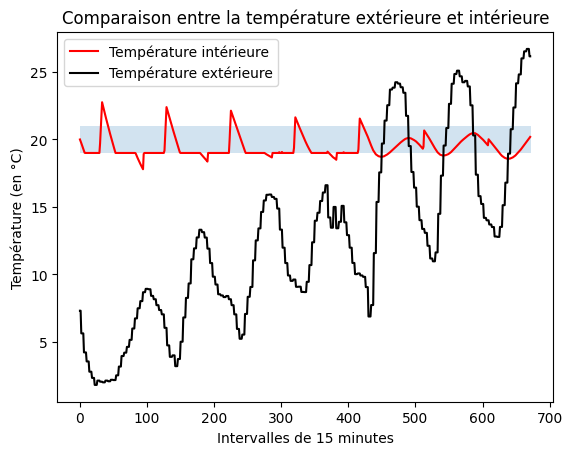

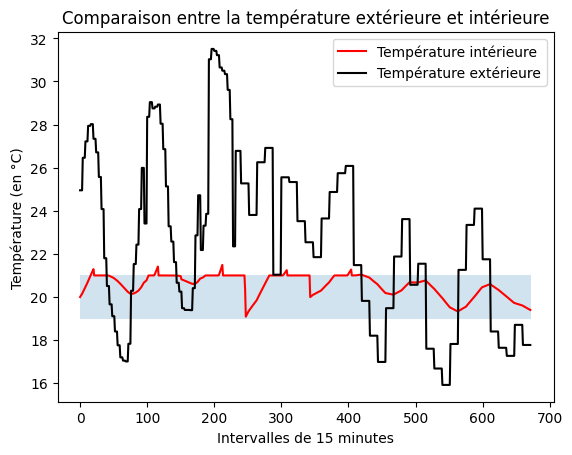

In [12]:
display_temperature(temperature_in, temperature_ext, 13050)
display_temperature(temperature_in2, temperature_ext, 18500)

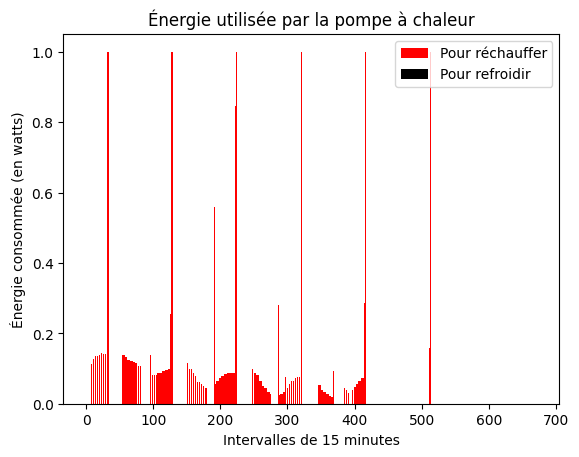

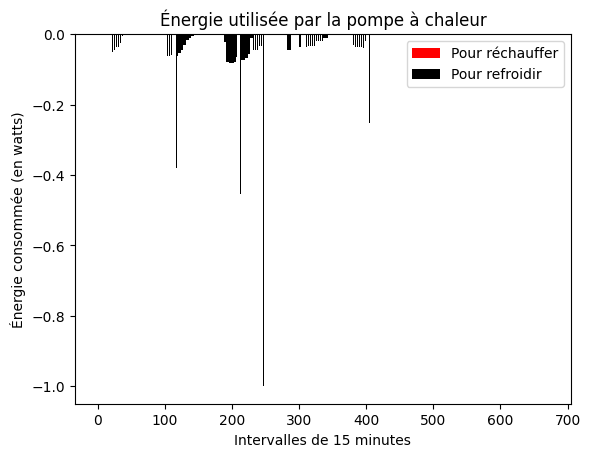

In [13]:
display_energy(énergie)
display_energy(énergie2)

# Commentaire
Nous avons fixé le budget à 90% du coût minimal trouvé à la tâche 1. On remarque sur le graphe que la température intérieure garde la même “forme générale” en prenant parfois des valeurs plus extrêmes vu qu’on ne doit pas strictement respecter l'intervalle [19; 21]. On remarque aussi que la pompe est moins souvent utilisée à cause de la limite de budget.

<div class="alert alert-block alert-info">On remplace à présent la notion d'inconfort décrite ci-dessus par une pénalisation quadratique : à présent l'inconfort  est proportionnel au *carré* du dépassement de la température maximale admissible, ou au *carré* du dépassement par le bas de la température minimale admissible (les coefficients de proportionnalité restent identiques).
</div>

<div class="alert alert-block alert-info"><b>Question 2.3</b> :<br> 
    Modélisez ce nouveau problème de façon linéaire, en utilisant une approximation. Cette approximation pourra par exemple être basée sur des tangentes  (choisissez un nombre pas trop élevé, par exemple 5). Expliquez votre technique de modélisation. Résolvez ce modèle approché, affichez les solutions et commentez (en particulier l'effet sur la solution par rapport au modèle d'inconfort initial).
</div>

# Variables de décision
Soit $I_i$ l'inconfort à l'intervalle $i$. \
Soit $c_i$ le coût à l'intervalle $i$.

# Objectif
Minimiser l'inconfort total
$\sum_{i = 0}^{n} I_i$ sachant que l'inconfort à l'intervalle $i$ peut être défini comme ceci :
$
\begin{cases}
I_i = I_i + 3 * (T\_min - T_i)^2 & T_i < T\_min \\
I_i = I_i + 1 * (T_i - T\_max)^2 & T_i > T\_max \\
0 & sinon\\
\end{cases}
$
\
\
\
On peut également la noter d'une manière moins conditionelle. En effet, on aimerait considérer uniquement $T_i \ge T\_max$, et rien dans le cas contraire. Grâce à la fonction max on peut transformer ce système en simple équation du style.\
$
I_i = 3 * (T\_min - T_i)^2 * max(T\_min - T_i, 0) + 1 * (T_i - T\_max)^2 * max(T_i - T\_max, 0) 
$

# Contraintes
$\sum_{i = 0}^{n} c_i \leq$ MAX\_BUDGET
\
\
\
L'inconfort à l'intervalle $i$ peut être approximé en utilisant une approximation basée sur des tangentes. L'idée est d'approximer la fonction non linéaire par des segments linéaires. On peut utiliser une approximation par tangentes avec un nombre donné de segments, par exemple 5 segments. Pour chaque segment, on approxime la fonction par une tangente reliant les deux points extrêmes du segment.

On peut approximer l'inconfort $I_i$ en utilisant des tangentes de la manière suivante :

$
I_i = 3 \cdot (T_{\text{min}} - T_i)^2 \cdot \max(T_{\text{min}} - T_i, 0) + 1 \cdot (T_i - T_{\text{max}})^2 \cdot \max(T_i - T_{\text{max}}, 0)
$

In [14]:
def task_2_p2a(MAX_BUDGET, start_idx, NO_TIME=False):
    days_offset = 96
    end_idx = start_idx + days_offset * 7
    depart = time.time()
    Tin = cp.Variable(shape=(end_idx - start_idx,)) # Température
    x = cp.Variable(end_idx - start_idx) # Energie
    T0 = 20
    contraintes = [Tin[0] == T0]
    cout_elec = [NIGHT_COST if is_night(start_idx) else DAY_COST]

    for i in range(1, end_idx - start_idx):
        cout_elec.append(NIGHT_COST) if is_night(i + start_idx) else cout_elec.append(DAY_COST)
        T1 = -(1 - ETA) * (Tin[i - 1] - temperatures_exterieurs[i + start_idx]) + Tin[i - 1]
        degre_a_compenser = degree_to_get(20, temperatures_exterieurs[i + start_idx], x[i])
        contraintes.append(T1 + degre_a_compenser == Tin[i])
        contraintes.append(x[i] <= MAX_ENERGY)
        contraintes.append(x[i] >= -MAX_ENERGY)

    contraintes.append(cp.sum(cp.multiply(cout_elec, cp.abs(x)), axis=0) <= MAX_BUDGET)
    segments = np.linspace(MIN_TEMP, MAX_TEMP, 5 + 1)
    segment_policies = []

    for i in range(5):
        segment_Tmin = segments[i]
        segment_Tmax = segments[i + 1]
        segment_Pmin = 3 * (MIN_TEMP - segment_Tmin) ** 2
        if MIN_TEMP <= segment_Tmin :
            segment_Pmin = 0
        segment_Pmax = 1 * (segment_Tmax - MAX_TEMP) ** 2
        if MAX_TEMP >= segment_Tmax :
            segment_Pmax = 0
        segment_Penalty = cp.minimum(segment_Pmin, segment_Pmax)
        segment_Slope = 2 * 3 * (MIN_TEMP - segment_Tmin)
        segment_policies.append(cp.maximum(segment_Slope * (Tin - segment_Tmin), 0) + segment_Penalty)

    segment_objective = cp.sum(segment_policies)
    objective = cp.sum(segment_objective)
    solution = cp.Problem(cp.Minimize(objective), contraintes)
    solution.solve()

    fin = time.time() - depart
    print(f"L'inconfort minimal avec un budget de {MAX_BUDGET} $ est de {solution.value}")
    
    if not NO_TIME:
        print(f"Temps de calcul : {fin} s")

    return solution.value, Tin, x.value, fin

In [15]:
min_inconfort_2_a, temperature_in_2_a, énergie_2_a, _ = task_2_p2a(max_budget, 13050)

L'inconfort minimal avec un budget de 7.529795788797497 $ est de 9051.856984906228
Temps de calcul : 1.9469316005706787 s


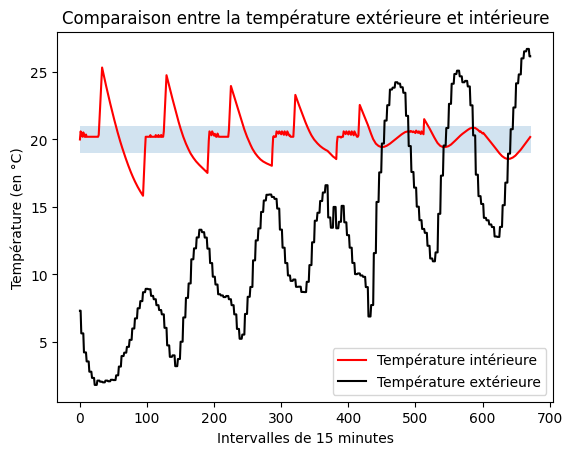

In [16]:
display_temperature(temperature_in_2_a, temperature_ext, 13050)

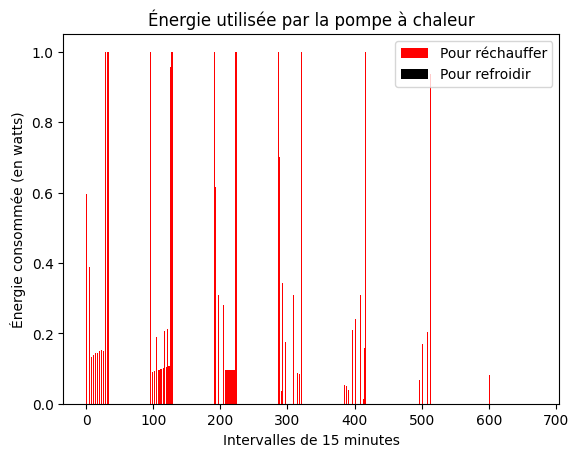

In [17]:
display_energy(énergie_2_a)

**Commentaires** :
Nous avons divisier l'intervalle de température admissible en 5 segments pour modéliser l'inconfort de façon non linéaire. On associe à chaque segment une tangente déterminée par la pente de la tangente au point de tansition du segment (Point entre deux segments). En utilisant la nouvelle formule de pénalité on voit qu'en effet la pénalité a augmenter exponantiellement. On remarque également que le graphe de la température intérieur garde la même "forme globale" que dans la première version du problème mais avec des valeurs plus extrême. Nous pensons que ces effets sont provoqué par l'erreur injecté par l'approximation.


<div class="alert alert-block alert-info"><b>Question 2.4</b> :<br> 
    Pour terminez cette partie, résolvez encore une fois ce nouveau modèle, mais cette fois de façon exacte, en utilisant un solveur quadratique. Comparez avec la solution approchée obtenue précédemment (allure de la solution, temps de calcul).
</div>

In [18]:
def task_2_p2b(MAX_BUDGET, start_idx, NO_TIME=False):
    MIN_PENALTY = 3
    MAX_PENALTY = 1
    days_offset = 96
    end_idx = start_idx + days_offset * 7
    depart = time.time()
    Tin = cp.Variable(end_idx - start_idx) # Température
    x = cp.Variable(end_idx - start_idx) # Energie
    T0 = 20
    contraintes = [Tin[0] == T0]
    cout_elec = [NIGHT_COST if is_night(start_idx) else DAY_COST]

    for i in range(1, end_idx - start_idx):
        cout_elec.append(NIGHT_COST) if is_night(i + start_idx) else cout_elec.append(DAY_COST)
        T1 = -(1 - ETA) * (Tin[i - 1] - temperatures_exterieurs[i + start_idx]) + Tin[i - 1]
        degre_a_compenser = degree_to_get(20, temperatures_exterieurs[i + start_idx], x[i])
        contraintes.append(T1 + degre_a_compenser == Tin[i])
        contraintes.append(x[i] <= MAX_ENERGY)
        contraintes.append(x[i] >= -MAX_ENERGY)

    contraintes.append(cp.sum(cp.multiply(cout_elec, cp.abs(x))) <= MAX_BUDGET)
    inconfort_func = lambda T: MIN_PENALTY * (MIN_TEMP - T) ** 2 + MAX_PENALTY * (T - MAX_TEMP) ** 2
    minimise_function = cp.sum(list(map(inconfort_func, Tin)))
    solution = cp.Problem(cp.Minimize(minimise_function), contraintes)
    solution.solve(solver=cp.ECOS)

    fin = time.time() - depart
    print(f"L'inconfort minimal avec un budget de {MAX_BUDGET} $ est de {solution.value}")

    if not NO_TIME:
        print(f"Temps de calcul : {fin} s")

    return solution.value, Tin, x.value, fin

In [19]:
min_inconfort_2_b, temperature_in_2_b, énergie_2_b, _ = task_2_p2b(max_budget, 13050)

L'inconfort minimal avec un budget de 7.529795788797497 $ est de 3002.0276094155183
Temps de calcul : 4.621137619018555 s


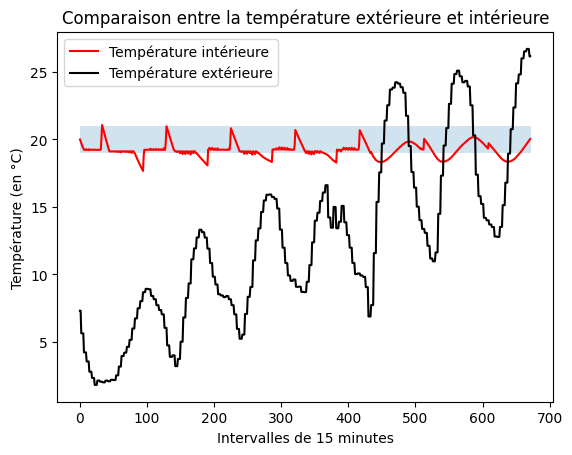

In [20]:
display_temperature(temperature_in_2_b, temperature_ext, 13050)

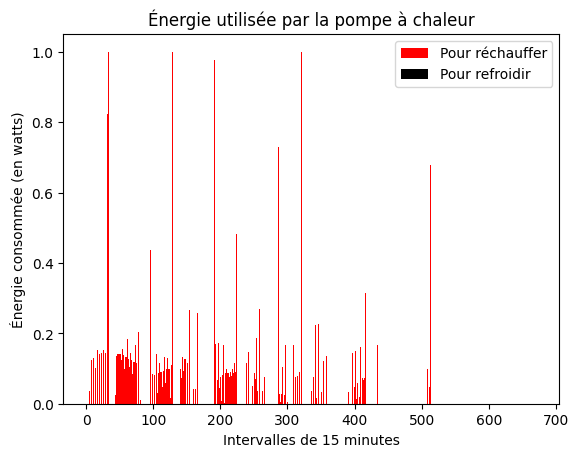

In [21]:
display_energy(énergie_2_b)

**Commentaires** : On voit que le graphe des températures ressemble bien plus au graphe du problème initiale comme attendu, de même que sa pénalité soit élevé mais beaucoup moins que celui de la solution approximée. Le temps d'exécution, bien que court, est 2x supérieur à celui de la solution approximé, ce qui est attendu lors de l'utilisation d'un solveur quadratique plutôt que linéaire.


**Tâche 3** : on voudrait à présent mieux comprendre le compromis qui existe entre le budget alloué et l'inconfort total qui en résulte. Proposez un **graphique représentant au mieux cette relation entre budget et inconfort**, où on fera varier le budget entre entre zéro et le coût minimal identifié lors de la tâche 1 (ce budget sera indiqué en pourcentage, de 0 à 100%). Ceci nécessitera la résolution de plusieurs problèmes, et il sera judicieux d'utiliser la fonctionnalité _warm start_ du solver pour accélérer les calculs.

<div class="alert alert-block alert-warning"><b>A mentionner</b> :<br> 
- graphique demandé + temps de calcul (total et moyenne par problème) + bref commentaire (maximum 4 lignes)<br>
- à nouveau pour les deux périodes mentionnées  lors des tâches 1 et 2
</div>

---

<div class="alert alert-block alert-info"><b>Question 3.1</b> :<br> 
    Fournissez le graphique et les commentaires demandé ci-dessus
</div>

In [10]:
# Calcul des données nécessaires
inconfort_total_par_pourcent = []
inconfort_total_par_pourcent2 = []
budget = [0, min_cost - 90*min_cost/100, min_cost - 80*min_cost/100, min_cost - 70*min_cost/100, min_cost - 60*min_cost/100, min_cost - 50*min_cost/100, min_cost - 40*min_cost/100, min_cost - 30*min_cost/100, min_cost - 20*min_cost/100, min_cost - 10*min_cost/100, min_cost]
print(budget)
total_time_budget_1 = 0
total_time_budget_2 = 0

for i in range(11):
    min_inconfort, temperature_in, énergie, _ 
    budget_1 = task_2(budget[i], 13050, NO_TIME=True)
    budget_2 = task_2(budget[i], 18500, NO_TIME=True)
    total_time_budget_1 += budget_1[3]
    total_time_budget_2 += budget_2[3]
    inconfort_total_par_pourcent.append(budget_1[0])
    inconfort_total_par_pourcent2.append(budget_2[0])

mean_time_budget_1 = total_time_budget_1 / len(budget)
mean_time_budget_2 = total_time_budget_2 / len(budget)

print(f"Temps total pour la première plage : {total_time_budget_1} s")
print(f"Temps moyens pour la première plage : {mean_time_budget_1} s")
print()
print(f"Temps total pour la deuxième plage : {total_time_budget_2} s")
print(f"Temps moyens pour la deuxième plage : {mean_time_budget_2} s")

[0, 0.8103963805652921, 1.6207927611305832, 2.431189141695876, 3.2415855222611683, 4.05198190282646, 4.862378283391752, 5.672774663957044, 6.4831710445223365, 7.293567425087629, 8.10396380565292]
L'inconfort minimal avec un budget de 0 $ est de 12814.284133449037
L'inconfort minimal avec un budget de 0 $ est de 1138.8629298427172
L'inconfort minimal avec un budget de 0.8103963805652921 $ est de 11099.811395851002
L'inconfort minimal avec un budget de 0.8103963805652921 $ est de 580.1133993843135
L'inconfort minimal avec un budget de 1.6207927611305832 $ est de 9408.674886744162
L'inconfort minimal avec un budget de 1.6207927611305832 $ est de 117.68513176584766
L'inconfort minimal avec un budget de 2.431189141695876 $ est de 7758.515706248589
L'inconfort minimal avec un budget de 2.431189141695876 $ est de 0.0
L'inconfort minimal avec un budget de 3.2415855222611683 $ est de 6113.029181952497
L'inconfort minimal avec un budget de 3.2415855222611683 $ est de 0.0
L'inconfort minimal avec

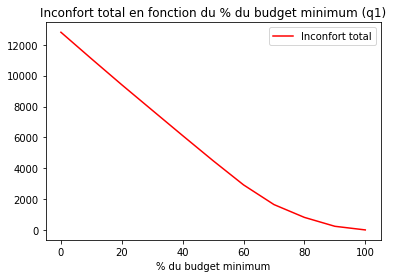

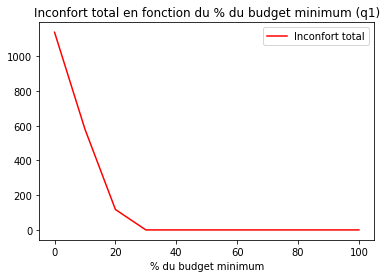

In [13]:
display_inconfort_budget(inconfort_total_par_pourcent, budget)
display_inconfort_budget(inconfort_total_par_pourcent2, budget)

# Commentaire
On remarque très nettement que l’inconfort total est inversement proportionnel au budget. Ce qui est totalement logique puisque la pompe peut être davantage utilisée pour maintenir une température optimale lorsqu’on a le budget pour lui permettre de tourner.

<div class="alert alert-block alert-info"><b>Question 3.2</b> :<br> 
    Expliquez la pente linéaire observée dans une grande partie du graphique obtenu. Recalculez la valeur de la pente à partir des informations fournies par le solver pour la résolution avec le budget maximal (tâche 2 initiale, Question 2.2), et comparez à celle du graphique. Enfin, expliquez pourquoi le graphique cesse à un moment d'être une droite.
</div>

La pente linéaire dans le graphique ci-dessus.
La valeure de la pente dans la tâche 2 est de :

---


<div class="alert alert-block alert-info"><b>Bonus</b><br>
    Estimez l'effet de l'utilisation d'une version imprécise des données de température (prévisions)<br>
</div>
Ce bonus est optionnel, et ne conduit pas à l'obtention de points supplémentaires : il est seulement destiné à attirer votre
    attention sur le caractère artificiel de la situation proposée, où on connaît parfaitement et à l'avance les températures extérieures.

## Consignes et conseils
- Le projet se réalise par groupe de (maximum) quatre étudiants (cf. groupes constitués sur Moodle). 

- L'assistant responsable du projet est Guillaume Van Dessel. Toutes les  questions sur le projet doivent être posées via Moodle dans le forum prévu pour le projet (et pas par message/mail individuel). Des permanences seront prévues, et seront annoncées via Moodle.

- Il est fortement suggéré d'utiliser un langage de modélisation pour formuler et résoudre vos problèmes d'optimisation linéaire. Nous conseillons d'utiliser le module CVXPY combiné au solver d'optimisation HIGHS (nous avons vérifié que cette combinaison est suffisamment performance pour le projet).

- Les groupes peuvent échanger leurs réflexions, partager leurs idées et comparer leurs résultats. Ils ne peuvent pas recopier les raisonnements, les solutions ou les codes informatiques. L'utilisation de toute information ou aide extérieure doit obligatoirement être mentionnée dans le rapport, en citant la source.

- Votre rapport final sera constitué de ce notebook complété, où vous aurez inséré vos codes, vos résultats, vos graphiques et commentaires.

- Ce rapport  est à remettre au plus tard le **mercredi 24 mai 2023** à minuit (soir), via Moodle, sous la forme d'une archive compressée contenant votre notebook et tous les fichiers nécessaires pour le faire fonctionner (code Python, etc.). Le notebook doit contenir les cellules sous forme déjà évaluée (résultats, tableaux, graphiques, etc.), mais doit pouvoir également être ré-évalué en entier. 

- Organisez efficacement votre travail de groupe, et répartissez vous le travail. Les tâches à effectuer durant cette seconde partie sont *largement indépendantes* les unes des autres.


### Changelog
- 2023-03-24 v1
- 2023-04-23 v1.1 avec récapitulatif des précisions apportées sur Moodle (en bleu)
- 2023-04-28 description des tâches de la seconde partie
- 2023-05-12 v2 avec le format attendu (notebook) pour le rapport final
- 2023-05-12 v2.1 précisions supplémentaire pour quelques questions